In [1]:
%matplotlib inline

import math
import matplotlib
import multiprocessing
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import date, datetime, timedelta
from fbprophet import Prophet
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

#### Input params ##################
stk_path = r"D:\PycharmProjects\FinanceData\TA_Data\STOCKs\TA_0050.csv"#r"./data/VTI_20130102_20181231.csv"
H = 21                          # Forecast horizon
train_size = 252*1              # Use 1 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                  # Use 1 year of data as validation set
changepoint_prior_scale_list = [0.05, 0.5, 1, 1.5, 2.5]     # for hyperparameter tuning
fourier_order_list = [None, 2, 4, 6, 8, 10]                 # for hyperparameter tuning
# holidays_path = "./data/holidays.csv"                       # csv file containing holidays in the US
window_list = [None, 0, 1, 2]                               # for hyperparameter tuning

fontsize = 14
ticklabelsize = 14
####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


No. of days in train+validation set = 504


In [2]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

def get_preds_prophet(df, H, changepoint_prior_scale=0.05, fourier_order=None, holidays=None):
    """
    Use Prophet to forecast for the next H timesteps, starting at df[len(df)]
    Inputs
        df: dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H : forecast horizon
        changepoint_prior_scale : to detect changepoints in time series analysis trajectories
        fourier_order           : determines how quickly seasonality can change
        holidays                : dataframe containing holidays you will like to model. 
                                  Must have 'holiday' and 'ds' columns
    Outputs
        A list of predictions
    """
    # Fit prophet model
    if holidays is not None:
        m = Prophet(changepoint_prior_scale=changepoint_prior_scale, holidays=holidays)
    else:
        m = Prophet(changepoint_prior_scale=changepoint_prior_scale)
    if (fourier_order is not None) and (~np.isnan(fourier_order)): # add monthly seasonality
        m.add_seasonality(name='monthly', period=21, fourier_order=int(fourier_order))

    m.fit(df)
    
    # Make future dataframe
    future = m.make_future_dataframe(periods=2*H)
    
    # Eliminate weekend from future dataframe
    future['day'] = future['ds'].dt.weekday
    future = future[future['day']<=4]
    
    # Predict
    forecast = m.predict(future) # Note this prediction includes the original dates
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    return forecast['yhat'][len(df):len(df)+H]
    
def get_error_metrics(df, H, train_size, val_size, changepoint_prior_scale=0.05, fourier_order=None, holidays=None):
    """
    Given a dataframe consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale: to detect changepoints in time series analysis trajectories
        fourier_order          : determines how quickly seasonality can change
        holidays               : dataframe containing holidays you will like to model. 
                                 Must have 'holiday' and 'ds' columns
    Outputs
        mean of rmse, mean of mape, mean of mae, dict of predictions
    """
    assert len(df) == train_size + val_size
    
    # Predict using Prophet, and compute error metrics also
    rmse = [] # root mean square error
    mape = [] # mean absolute percentage error
    mae = []  # mean absolute error
    preds_dict = {}
    
    rmse_mean, mape_mean, mae_mean = get_preds_prophet_parallelized(df, H, changepoint_prior_scale, fourier_order, holidays)

    return rmse_mean, mape_mean, mae_mean, _

def hyperparam_tune_cp(df, H, train_size, val_size, changepoint_prior_scale_list):
    """
    Hyperparameter tuning - changepoint
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale_list: list of changepoint_prior_scale values to try
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for changepoint_prior_scale in tqdm_notebook(changepoint_prior_scale_list):
        print("changepoint_prior_scale = " + str(changepoint_prior_scale))
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, H, train_size, val_size, changepoint_prior_scale)
        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
    
    # Create results dataframe
    results = pd.DataFrame({'changepoint_prior_scale': changepoint_prior_scale_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
    
    # Return hyperparam corresponding to lowest error metric
    return changepoint_prior_scale_list[np.argmin(rmse_mean_list)], results

def hyperparam_tune_fo(df, H, train_size, val_size, fourier_order_list):
    """
    Hyperparameter tuning - fourier order
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        fourier_order_list     : list of fourier_order values to try
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for fourier_order in tqdm_notebook(fourier_order_list):
        print("fourier_order = " + str(fourier_order))
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, H, train_size, val_size, 0.05, fourier_order)
        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
        
    # Create results dataframe
    results = pd.DataFrame({'fourier_order': fourier_order_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
        
    # Return hyperparam corresponding to lowest error metric
    return fourier_order_list[np.argmin(rmse_mean_list)], results

def hyperparam_tune_wd(df, H, train_size, val_size, window_list, holidays):
    """
    Hyperparameter tuning - upper and lower windows for holidays
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        window_list            : list of upper and lower window values to try
        holidays               : dataframe containing holidays you will like to model. 
                                 Must have 'holiday' and 'ds' columns
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for window in tqdm_notebook(window_list):
        print("window = " + str(window))
        
        if window is None:
            rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df=df, 
                                                                  H=H, 
                                                                  train_size=train_size, 
                                                                  val_size=val_size, 
                                                                  holidays=None)
        else:
            # Add lower_window and upper_window which extend the holiday out to 
            # [lower_window, upper_window] days around the date
            holidays['lower_window'] = -window
            holidays['upper_window'] = +window
        
            rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df=df, 
                                                                  H=H, 
                                                                  train_size=train_size, 
                                                                  val_size=val_size, 
                                                                  holidays=holidays)
        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
        
    # Create results dataframe
    results = pd.DataFrame({'window': window_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
        
    # Return hyperparam corresponding to lowest error metric
    return window_list[np.argmin(rmse_mean_list)], results

def hyperparam_tune_cp_fo_wd(df, H, train_size, val_size, changepoint_prior_scale_list, 
                             fourier_order_list, window_list, holidays):
    """
    Hyperparameter tuning - changepoint, fourier_order, holidays
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale_list: list of changepoint_prior_scale values to try
        fourier_order_list          : list of fourier_order values to try
        window_list                 : list of upper and lower window values to try
        holidays                    : dataframe containing holidays you will like to model. 
                                      Must have 'holiday' and 'ds' columns
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    cp_list = []
    fo_list = []
    wd_list = []
    for changepoint_prior_scale in tqdm_notebook(changepoint_prior_scale_list):
        for fourier_order in tqdm_notebook(fourier_order_list):
            for window in tqdm_notebook(window_list):
                
                if window is None:
                    rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, 
                                                                          H, 
                                                                          train_size, 
                                                                          val_size, 
                                                                          changepoint_prior_scale, 
                                                                          fourier_order, 
                                                                          holidays=None)
                else:
                    # Add lower_window and upper_window which extend the holiday out to 
                    # [lower_window, upper_window] days around the date
                    holidays['lower_window'] = -window
                    holidays['upper_window'] = +window
        
                    rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, 
                                                                          H, 
                                                                          train_size, 
                                                                          val_size, 
                                                                          changepoint_prior_scale, 
                                                                          fourier_order, 
                                                                          holidays)
                rmse_mean_list.append(rmse_mean)
                mape_mean_list.append(mape_mean)
                mae_mean_list.append(mae_mean)
                cp_list.append(changepoint_prior_scale)
                fo_list.append(fourier_order)
                wd_list.append(window)
        
    # Return hyperparam corresponding to lowest error metric
    results = pd.DataFrame({'changepoint_prior_scale': cp_list, 
                            'fourier_order': fo_list,
                            'window': wd_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
    temp = results[results['rmse'] == results['rmse'].min()]
    changepoint_prior_scale_opt = temp['changepoint_prior_scale'].values[0]
    fourier_order_opt = temp['fourier_order'].values[0]
    window_opt = temp['window'].values[0]
    
    return changepoint_prior_scale_opt, fourier_order_opt, window_opt, results

def processInput(i, df, H, changepoint_prior_scale, fourier_order, holidays):
    preds_list = get_preds_prophet(df[i-train_size:i], H, changepoint_prior_scale, fourier_order, holidays)
    
    # Compute error metrics
    rmse = get_rmse(df[i:i+H]['y'], preds_list)
    mape = get_mape(df[i:i+H]['y'], preds_list)
    mae = get_mae(df[i:i+H]['y'], preds_list)
    
    return (rmse, mape, mae)

def get_preds_prophet_parallelized(df, H, changepoint_prior_scale=0.05, fourier_order=None, holidays=None):
    """
    This is a parallelized implementation of get_preds_prophet.
    Given a dataframe consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale: to detect changepoints in time series analysis trajectories
        fourier_order          : determines how quickly seasonality can change
        holidays               : dataframe containing holidays you will like to model. 
                                 Must have 'holiday' and 'ds' columns
    Outputs
        mean of rmse, mean of mape, mean of mae, dict of predictions
    """
    inputs = range(train_size, len(df)-H, int(H/2))

    num_cores = multiprocessing.cpu_count()

    results = Parallel(n_jobs=num_cores)(delayed(processInput)(i, df, H, changepoint_prior_scale, fourier_order, holidays) for i in inputs)
    # results has format [(rmse1, mape1, mae1), (rmse2, mape2, mae2), ...]

    rmse = [errors[0] for errors in results]
    mape = [errors[1] for errors in results]
    mae = [errors[2] for errors in results]
    
    return np.mean(rmse), np.mean(mape), np.mean(mae)

In [3]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

# Get size of dataframe
print("len(df) = " + str(len(df)))

df.head(10)

len(df) = 3898


date   open   high    low  close  volume     1-day  1-day-bin  \
0 2003-12-18  45.40  45.40  45.20  45.40  5103.0 -0.005507         10   
1 2003-12-19  45.59  45.60  45.12  45.15  5240.0  0.013953         12   
2 2003-12-22  45.15  45.80  45.15  45.78  3920.0  0.000437         11   
3 2003-12-23  45.78  45.81  45.60  45.80  1645.0  0.002183         11   
4 2003-12-24  45.80  46.15  45.70  45.90  1029.0 -0.001961         11   
5 2003-12-25  45.99  46.11  45.81  45.81   783.0 -0.001310         11   
6 2003-12-26  45.90  46.10  45.70  45.75  1869.0 -0.007213         10   
7 2003-12-29  45.75  45.82  45.30  45.42  3893.0  0.010568         12   
8 2003-12-30  45.79  45.90  45.45  45.90  4803.0  0.000436         11   
9 2003-12-31  46.00  46.08  45.90  45.92  3519.0  0.030052         14   

      2-day  2-day-bin  ...      macd  macdsignal  macdhist      rsi_s  \
0  0.008370         22  ... -0.223593   -0.201934 -0.021660  32.954605   
1  0.014396         23  ... -0.266530   -0.214853 -0.051677  27.587628   
2  0.002621         22  ... -0.246876   -0.221258 -0.025618  52.140128   
3  0.000218         22  ... -0.227069   -0.222420 -0.004649  52.775531   
4 -0.003268         21  ... -0.200985   -0.218133  0.017148  56.393841   
5 -0.008513         21  ... -0.185439   -0.211594  0.026155  51.918621   
6  0.003279         22  ... -0.175931   -0.204462  0.028530  48.698188   
7  0.011008         23  ... -0.192803   -0.202130  0.009327  34.139530   
8  0.030501         25  ... -0.165533   -0.194810  0.029278  57.332039   
9  0.040941         26  ... -0.140686   -0.183986  0.043300  58.100516   

       rsi_l      slowk      slowd  aroondown    aroonup   aroonosc  
0  40.706101  34.364500  48.356270  92.857143  71.428571 -21.428571  
1  38.266740  21.249360  35.406948  85.714286  64.285714 -21.428571  
2  46.902077  35.297804  30.303888  78.571429  57.142857 -21.428571  
3  47.154797  48.701684  35.082949  71.428571  50.000000 -21.428571  
4  48.475279  68.568058  50.855849  64.285714  42.857143 -21.428571  
5  47.329023  69.795038  62.354927  57.142857  35.714286 -21.428571  
6  46.538943  67.572816  68.645304  50.000000  28.571429 -21.428571  
7  42.351402  47.035979  61.467944  42.857143  21.428571 -21.428571  
8  49.473008  48.235294  54.281363  35.714286  14.285714 -21.428571  
9  49.751546  53.749697  49.673657  28.571429   7.142857 -21.428571  

[10 rows x 47 columns]

In [4]:
df['date'].min(), df['date'].max() 

(Timestamp('2003-12-18 00:00:00'), Timestamp('2019-09-20 00:00:00'))

Text(0, 0.5, 'TW')

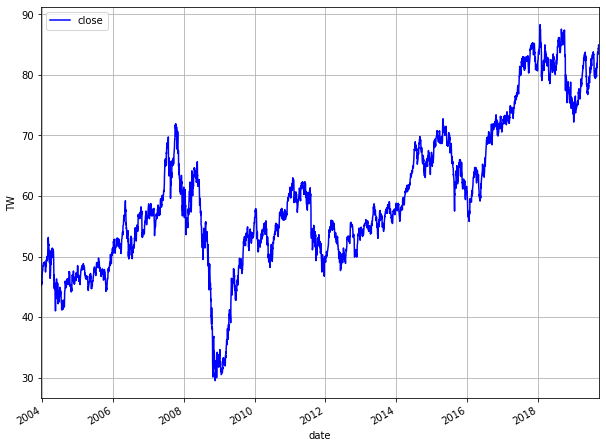

In [5]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("TW")

In [6]:
# Prepare dataframe for Prophet
df_prophet = df[['date', 'close']].rename(columns={'date':'ds', 'close':'y'})
df_prophet.head()

ds      y
0 2003-12-18  45.40
1 2003-12-19  45.15
2 2003-12-22  45.78
3 2003-12-23  45.80
4 2003-12-24  45.90

# Predict for a specific H (forecast horizon) and a specific date

In [7]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_prophet.iloc[i]['ds'], H))

Predicting on day 504, date 2005-12-28 00:00:00, with forecast horizon H = 21


In [8]:
# Fit prophet model
m = Prophet(changepoint_prior_scale=1)
m.fit(df_prophet[i-train_val_size:i])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
# Create dataframe with the dates we want to predict
future = m.make_future_dataframe(periods=2*H)

According to https://facebook.github.io/prophet/docs/non-daily_data.html, since we do not have weekend data, we should eliminate it from the future dataframe before doing predictions.

In [10]:
# Eliminate weekend from future dataframe
future['day'] = future['ds'].dt.weekday
future = future[future['day']<=4]

# Predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
529 2006-02-01  52.898592   48.828463   57.527030
530 2006-02-02  52.917667   48.682463   57.782218
531 2006-02-03  52.910439   48.535696   58.098344
532 2006-02-06  52.826951   47.523424   58.826888
533 2006-02-07  52.893067   47.617346   59.328092

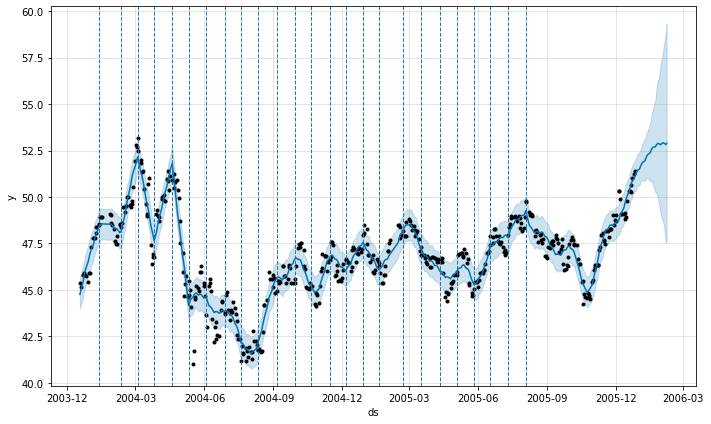

In [11]:
# Plot
m.plot(forecast);
for changepoint in m.changepoints:
    plt.axvline(changepoint,ls='--', lw=1)

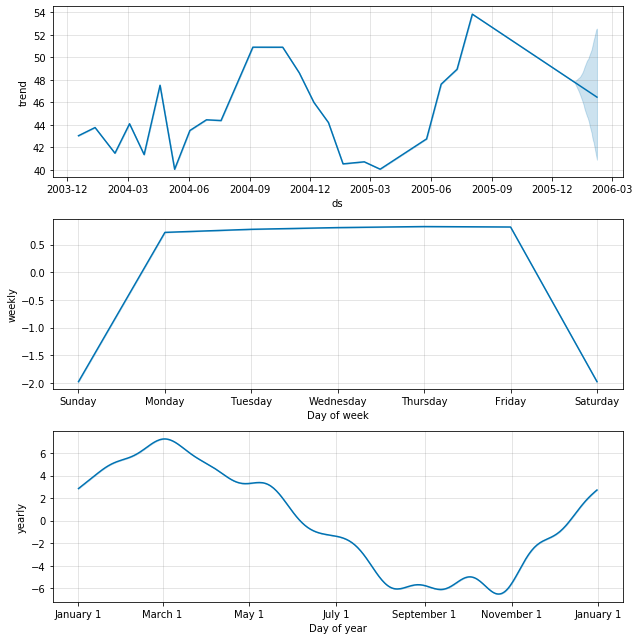

In [12]:
# Plot components
m.plot_components(forecast);

In [13]:
# Compute error metrics
preds_list = forecast['yhat'][train_val_size:train_val_size+H]
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))

For forecast horizon 21, predicting on day 504, date 2005-12-28 00:00:00, the RMSE is 0.968491
For forecast horizon 21, predicting on day 504, date 2005-12-28 00:00:00, the mean MAPE is 1.431495
For forecast horizon 21, predicting on day 504, date 2005-12-28 00:00:00, the mean MAE is 0.735850


(732288.0, 732329.0)

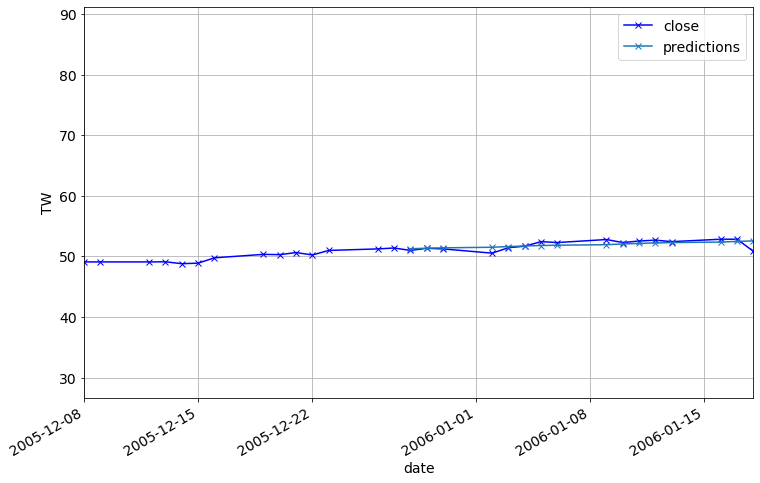

In [14]:
# Plot the predictions
rcParams['figure.figsize'] = 12, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = df.plot(x='date', y='close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("TW")
ax.legend(['close', 'predictions'])
# ax.set_ylim([92, 105])
ax.set_xlim([date(2005, 12, 8), date(2006, 1, 18)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - changepoint

In [16]:
# # Get optimum hyperparams
# tic = time.time()
# changepoint_opt, results = hyperparam_tune_cp(df_prophet[i-train_val_size:i], 
#                                               H, 
#                                               train_size, 
#                                               val_size, 
#                                               changepoint_prior_scale_list)
# toc = time.time()
# print("Time taken = " + str((toc-tic)/60.0) + " mins")

# print("changepoint_opt = " + str(changepoint_opt))

# results

In [17]:
# # Get predictions using tuned hyperparams
# preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], H, changepoint_prior_scale=changepoint_opt)
# print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
# print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
# print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))

In [18]:
# # Plot the predictions
# rcParams['figure.figsize'] = 10, 8 # width 10, height 8

# ax = df.plot(x='date', y='close', style='bx-', grid=True)

# # Plot the predictions
# ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
# ax.set_xlabel("date")
# ax.set_ylabel("USD")
# ax.legend(['close', 'predictions'])
# ax.set_ylim([92, 105])
# ax.set_xlim([date(2014, 12, 1), date(2015, 2, 28)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - monthly seasonality

In [19]:
# # Get optimum hyperparams
# tic = time.time()
# fourier_order_opt, results = hyperparam_tune_fo(df_prophet[i-train_val_size:i], 
#                                                 H, 
#                                                 train_size, 
#                                                 val_size, 
#                                                 fourier_order_list)
# toc = time.time()
# print("Time taken = " + str((toc-tic)/60.0) + " mins")

# print("fourier_order_opt = " + str(fourier_order_opt))

# results

In [20]:
# # Get predictions using tuned hyperparams
# preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], H, fourier_order=fourier_order_opt)
# print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
# print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
# print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))

In [21]:
# # Plot the predictions
# rcParams['figure.figsize'] = 10, 8 # width 10, height 8

# ax = df.plot(x='date', y='close', style='bx-', grid=True)

# # Plot the predictions# Get predictions using tuned hyperparams
# preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], H, fourier_order=fourier_order_opt)
# print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
# print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
# print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))
# ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
# ax.set_xlabel("date")
# ax.set_ylabel("USD")
# ax.legend(['close', 'predictions'])
# ax.set_ylim([92, 105])
# ax.set_xlim([date(2014, 12, 1), date(2015, 2, 28)])